# Solar Technician Movement Analysis

Installing haversine library for calculating distances between WG2 84 lat,long points
Matplotlib for visualizing movement

In [55]:
!pip install haversine
!pip install matplotlib

  Using cached haversine-2.3.0-py2.py3-none-any.whl (5.5 kB)


Importing necessary libraries

In [56]:
import pandas as pd
import numpy as np
from haversine import haversine
from haversine import Unit
import json

Data loaded into dictionary format

In [57]:
with open('api_techician_response_data.json') as f:
  data = json.load(f) 

The distances between the techs are loaded into a dataframe. I included separate columns for each pair of solar technicians. As a result this method of processing the data would have to change if there are more than 3 technicians. If the number of technicians is dynamic, a non-tabular format would work better. 

In [40]:
tech_distance_data = pd.DataFrame(columns=['tsecs', 'tminutes', 
                                           'DistanceBetweenTech1_2(Ft)', 'DistanceBetweenTech1_3(Ft)', 
                                           'DistanceBetweenTech2_3(Ft)', 'IsTech1_2Close', 
                                           'IsTech1_3Close', 'IsTech2_3Close'])

The data is parsed and processed. Using the haversine function the distances are calculated and converted to Feet, and formatted in a dictionary that can be added to the DataFrame. 

In [58]:
def construct_row(minute_data):
    tech_data = minute_data['features']
    tsecs = tech_data[0]['properties']['tsecs']
    
    tech_three_loc = tech_data[0]['geometry']['coordinates']
    
    tech_one_loc = tech_data[1]['geometry']['coordinates']
    
    tech_two_loc = tech_data[2]['geometry']['coordinates']
    
    #Haversine distance used radius of the earth to calculate distance betweeen points on a sphere
    #Assumes earth is perfectly spherical, and that the radius is constant throughout the earth
    #This assumption isn't perfectly true, ellipsoidal calculation would improve accuracy, but for
    #these small distances the difference is negligible. 
    
    one_two_distance = haversine(tech_two_loc, tech_one_loc, unit=Unit.FEET)
    one_three_distance = haversine(tech_three_loc, tech_one_loc, unit=Unit.FEET)
    two_three_distance = haversine(tech_three_loc, tech_two_loc, unit=Unit.FEET)
    
    is_one_two_close = int(one_two_distance <= 1000)
    is_one_three_close = int(one_three_distance <= 1000)
    is_two_three_close = int(two_three_distance <= 1000)
    
    row = {
        'tsecs': tsecs,  
        'tminutes': tsecs / 60, 
        'DistanceBetweenTech1_2(Ft)': one_two_distance, 
        'DistanceBetweenTech1_3(Ft)': one_three_distance, 
        'DistanceBetweenTech2_3(Ft)': two_three_distance, 
        'IsTech1_2Close': is_one_two_close,  
        'IsTech1_3Close': is_one_three_close, 
        'IsTech2_3Close': is_two_three_close
    }
    
    return row

Appending each row to the distance dataframe

In [59]:
for minute_data in data:
    tech_distance_data = tech_distance_data.append(construct_row(minute_data), ignore_index=True)

This dataframe is just for visualization and for estimating future locations of technicians, this is why just the lat,lon, and bearing are loaded into the dataframe

In [60]:
tech_location_data = pd.DataFrame(columns=['relminute', 
                                           'Tech_One_Lat', 'Tech_One_Lon', 'Tech_One_Bearing', 
                                           'Tech_Two_Lat', 'Tech_Two_Lon', 'Tech_Two_Bearing', 
                                           'Tech_Three_Lat', 'Tech_Three_Lon', 'Tech_Three_Bearing'])

Loading the location data along with the minute, relative to the start of the data. This could be a dynamic input if the function has to be used elsewhere

In [61]:
def construct_location_row(minute_data):
    tech_data = minute_data['features']
    tsecs = tech_data[0]['properties']['tsecs']
    tminute = tech_data[0]['properties']['tsecs'] / 60
    relminute = tminute % 26534640.0
    
    tech_three_bearing = tech_data[0]['properties']['bearing']
    tech_three_loc = tech_data[0]['geometry']['coordinates']
    
    tech_three_lat = tech_three_loc[0]
    tech_three_lon = tech_three_loc[1]
    
    tech_one_bearing = tech_data[1]['properties']['bearing']
    tech_one_loc = tech_data[1]['geometry']['coordinates']
    
    tech_one_lat = tech_one_loc[0]
    tech_one_lon = tech_one_loc[1]
    
    tech_two_bearing = tech_data[2]['properties']['bearing']
    tech_two_loc = tech_data[2]['geometry']['coordinates']
    
    tech_two_lat = tech_two_loc[0]
    tech_two_lon = tech_two_loc[1]
    
    
    row = {
        'relminute': relminute,
        'Tech_One_Lat': tech_one_lat, 
        'Tech_One_Lon': tech_one_lon, 
        'Tech_One_Bearing': tech_one_bearing, 
        'Tech_Two_Lat': tech_two_lat, 
        'Tech_Two_Lon': tech_two_lon, 
        'Tech_Two_Bearing': tech_two_bearing,
        'Tech_Three_Lat': tech_three_lat, 
        'Tech_Three_Lon': tech_three_lon,  
        'Tech_Three_Bearing': tech_three_bearing
    }
    
    return row
    

In [62]:
for minute_data in data:
    tech_location_data = tech_location_data.append(construct_location_row(minute_data), ignore_index=True)

Basic scatterplot lat,long positions of each of the technicians. The times are not displayed, but the graph is meant to give a basic understanding of the shape of the movement of each technician.

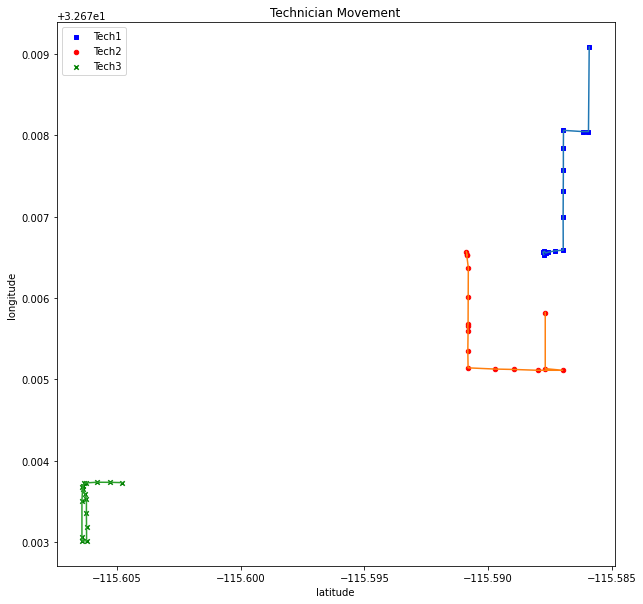

In [63]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(tech_location_data['Tech_One_Lat'], tech_location_data['Tech_One_Lon'], s=20, c='b', marker="s", label='Tech1')
ax1.plot(tech_location_data['Tech_One_Lat'], tech_location_data['Tech_One_Lon'])

ax1.scatter(tech_location_data['Tech_Two_Lat'], tech_location_data['Tech_Two_Lon'], s=20, c='r', marker="o", label='Tech2')
ax1.plot(tech_location_data['Tech_Two_Lat'], tech_location_data['Tech_Two_Lon'])

ax1.scatter(tech_location_data['Tech_Three_Lat'], tech_location_data['Tech_Three_Lon'], s=20, c='g', marker="x", label='Tech3')
ax1.plot(tech_location_data['Tech_Three_Lat'], tech_location_data['Tech_Three_Lon'])

plt.legend(loc='upper left');
plt.title('Technician Movement')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()